In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import scipy.io as sio

In [2]:
"""
data = sio.loadmat('mnist.mat')


Xtrain = data['trainX'][:10000,:].astype(int)
Xtest = data['testX'].astype(int)
ytrain =data['trainY'][0,:10000].astype(int)
ytest =  data['testY'][0,:].astype(int)

idx = np.logical_or(np.equal(ytrain,4), np.equal(ytrain,9))
Xtrain = Xtrain[idx,:]
ytrain = ytrain[idx]
ytrain[np.equal(ytrain,4)] = 1
ytrain[np.equal(ytrain,9)] = -1

idx = np.logical_or(np.equal(ytest,4), np.equal(ytest,9))
Xtest = Xtest[idx,:]
ytest = ytest[idx]
ytest[np.equal(ytest,4)] = 1
ytest[np.equal(ytest,9)] = -1


sio.savemat('mnist_binary_small.mat',{'Xtrain':Xtrain,'ytrain':ytrain,'Xtest':Xtest,'ytest':ytest})
"""

data = sio.loadmat('mnist_binary_small.mat')
Xtrain = data['Xtrain']
Xtest = data['Xtest']
ytrain = data['ytrain'][0,:]
ytest = data['ytest'][0,:]

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)


(1958, 784) (1991, 784) (1958,) (1991,)


In [3]:
from sklearn.tree import DecisionTreeClassifier
import math
clf = DecisionTreeClassifier(max_depth = 1)
clf = clf.fit(Xtrain,ytrain)

def get_weighted_misclass(w,y,yhat):
    val = w[(yhat != y)].sum()
    return val

def get_misclass(y,yhat):
    counter = 0
    counterT = 0
    i = 0
    while i < len(yhat):
        if yhat[i] == y[i]:
            counter +=1
        i+=1
        counterT +=1
    return (1 - counter/counterT) * 100

def get_exp_loss(y,yhat):
    
    x = (y * yhat)
    z = (np.exp(-x)).sum()
    return z * (1 / len(y))


print(get_misclass(clf.predict(Xtrain),ytrain))
print(get_misclass(clf.predict(Xtest),ytest))
print(get_exp_loss(clf.predict(Xtrain),ytrain))

10.980592441266602
15.268709191361129
0.6259675480492948


In [4]:
i = 1
misclassTrain = []
misclassTest = []
expTrain = []
depth = []

while i <= 100:
    dec = DecisionTreeClassifier(max_depth = i)
    dec = dec.fit(Xtrain,ytrain)
    a = get_misclass(dec.predict(Xtrain),ytrain)
    b = get_misclass(dec.predict(Xtest),ytest)
    c = get_exp_loss(dec.predict(Xtrain),ytrain)
    misclassTrain.append(a)
    misclassTest.append(b)
    expTrain.append(c)
    depth.append(i)
    i+=1
print(min(misclassTrain))
print(min(misclassTest))
print(min(expTrain))

0.0
5.223505775991965
0.3678794411714424


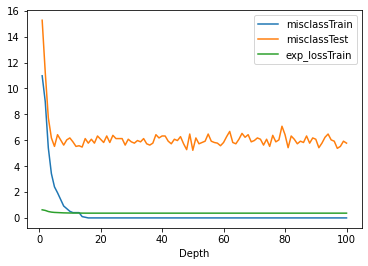

In [5]:
import matplotlib.pyplot as plt

plt.plot(depth, misclassTrain, label = 'misclassTrain')
plt.plot(depth, misclassTest, label = 'misclassTest')
plt.plot(depth, expTrain, label = 'exp_lossTrain')
plt.xlabel('Depth')
plt.legend(loc='upper right')
plt.show()

In [7]:
X = Xtrain
y = ytrain
n = X.shape[0]
iters = 100

# init numpy arrays
weights = np.zeros(shape=(iters, n))
stumps = np.zeros(shape=iters, dtype=object)
stump_weights = np.zeros(shape=iters)
errors = np.zeros(shape=iters)
errorst= np.zeros(shape=iters)
loss = np.zeros(shape=iters)
a = np.zeros(shape=iters)
e = np.zeros(shape=iters)
ts = np.zeros(shape=iters)


weights[0] = np.ones(shape=n) / n

for t in range(iters):
    curr_weights = weights[t]
    stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
    stump = stump.fit(X, y, sample_weight=curr_weights)

    pred = stump.predict(X)
    val = get_weighted_misclass(curr_weights ,y,pred)
    stump_weight = np.log((1 - val) / val) / 2
    e[t] = val
    a[t] = stump_weight


    new_weights = (
        curr_weights * np.exp(-stump_weight * y * pred)
    )
    new_weights /= new_weights.sum()

    if t+1 < iters:
        weights[t+1] = new_weights

    stumps[t] = stump
    errors[t] = val * 100
    errorst[t] = get_misclass(stump.predict(Xtest),ytest) 
    loss[t] = get_exp_loss(stump.predict(Xtrain),ytrain)
    ts[t] = t
print(min(errors))
print(min(errorst))
print(min(loss))

10.9805924412666
15.268709191361129
0.6259675480492948


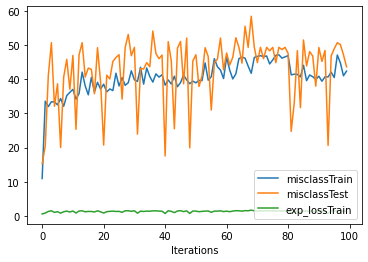

In [8]:
plt.plot(ts, errors, label = 'misclassTrain')
plt.plot(ts, errorst, label = 'misclassTest')
plt.plot(ts, loss, label = 'exp_lossTrain')
plt.xlabel('Iterations')
plt.legend(loc='lower right')
plt.show()

The Deep Decision Tree stumps performed better and more predictable than the implemented boosted method as in the above min values and graphs. 

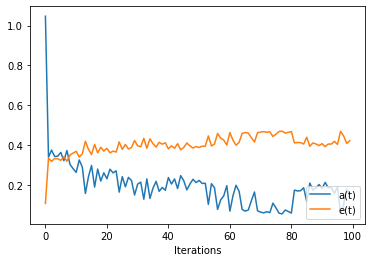

In [10]:
plt.plot(ts, a, label = 'a(t)')
plt.plot(ts, e, label = 'e(t)')
plt.xlabel('Iterations')
plt.legend(loc='lower right')
plt.show()

As seen in the graph, the performance of e(t) gradually increases as the iterations increase while the a(t) while fluctuating, continues to decrease with iterations. As seen in the graph they both heaviliy fluctaute with each boost, however the ove